In [ ]:
#Computação científica
import numpy as np

#análise de dados
import pandas as pd

#machine learning
from sklearn.linear_model import LogisticRegression #regressão lasso
from sklearn.model_selection import GridSearchCV, KFold
import lightgbm as lgb


#mtricas
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve


#visualização
import matplotlib.pyplot as plt
import seaborn as sns

#sampling
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

#pipeline
from imblearn.pipeline import Pipeline

#cross validation
from sklearn.model_selection import StratifiedKFold

from tqdm import tqdm




/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


#Parâmetros

In [ ]:
#Definir a seed para que os resultados obtidos sejam sempre os mesmos

seed=0

In [120]:
#Estilo dos gráficos do seaborn

sns.set_theme(style="darkgrid")


# Carregar *Dados*

In [ ]:
path='/content/drive/MyDrive/Rodolfo/porto/porto-seguro-safe-driver-prediction/'



No processo de feature engineering foram criados dois datasets:

1.   Dataset com todas as features iniciais;
2.   Dataset com algumas das features removidas de acordo com resultados obtidos em calculos de correlação



In [ ]:
#Dados com todas as colunas:

x_train_complete = pd.read_csv(path+'train_complete_transformed.csv')
x_val_complete   = pd.read_csv(path+'val_complete_transformed.csv')

y_train_complete = np.ravel(pd.read_csv(path+'y_train.csv'))
y_val_complete   = np.ravel(pd.read_csv(path+'y_val.csv'))

print("Número de features: {}".format(np.shape(x_train_complete)[1]))

Número de features: 132


In [ ]:
#Dados com colunas selecionadas através do calculo da correlação

x_train_corr = pd.read_csv(path+'train_selected_features_transformed.csv')
x_val_corr   = pd.read_csv(path+'val_selected_features_transformed.csv')

y_train_corr = np.ravel(pd.read_csv(path+'y_train.csv'))
y_val_corr   = np.ravel(pd.read_csv(path+'y_val.csv'))

print("Número de features: {}".format(np.shape(x_train_corr)[1]))

Número de features: 108


In [ ]:
#Função para treinar modelo com stratifiedkfold
def calcular_auc_stratifiedkfold(model,x,y,n_splits=10):
  """
  Função para treinar um modelo com o uso de stratifiedkfold e retornar uma lista com
  o roc_auc score para os dados de cada uma das folds

  Inputs:
    model    - instância de um objeto. O objeto é um modelo que será usado no treinamento
    x        - (pandas dataframe) dados de entrada do modelo
    y        - (np array) output esperado do moldelo
    n_splits - (int) número de splits usadas na validação cruzada

  Outputs
    auc     - (list) lista com o auc score obtido com os dados separados para teste na validação cruzada
   """

  #criação de objeto stratifiedkfold
  skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
  auc=[]
  progress_bar = tqdm(total=n_splits)
  for train_index, test_index in skf.split(x, y):
      x_train_fold, x_test_fold = x.loc[train_index,:], x.loc[test_index,:]
      y_train_fold, y_test_fold = y[train_index], y[test_index]
      model.fit(x_train_fold, y_train_fold)
      auc.append(roc_auc_score(y_test_fold,model.predict_proba(x_test_fold)[:,1]))
      progress_bar.update(1)
  return auc

In [ ]:
def treinar_modelos_feature_selection(modelo,x,y,feature_importance,quantiles=[0,0.25,0.5,0.75],feature_importance_column='Coefficient',feature_name_column='Feature'):
  '''
  Função para treinar um modelo com datasets contendo diferentes números de features. As features contidadas em cada dataset serão selecionadas de acordo com valores de feature
  importance previamente calculadas

  Inputs:
    modelo - intância de um objeto que será treinado com os diferentes datasets
    x      - pandas dataframe com o dataset com todas as features iniciais
    y      - numpy array com output esperados
    feature_importance - panda dataframe com duas colunas: na coluna feature_name_column estão os nomes das features e na coluna feature_importance_column estão os valores
                         das features importances de cada coluna
    quantiles - (list) valores que serão usados para seleção das features. Por exemplo, se quantile=0.5 então somente serão usadas as features com feature importance superior a mediana.
                O padrão de quantiles é  [0,0.25,0.5,0.75]. Isso significa que o modelo será treinado com todas as features com feature importance superior a zero, em seguida com as com feature
                importance superiores ao primeiro qurtil e assim sucessivamente
    feature_importance_column - string com o nome da coluna no dataframe feature_importance que contém os valores das feature importance de cada feature
    feature_name_column       - string com o nome da coluna no dataframe com o nome das features
  '''
  initial_n_features=0
  resultados={} #resultados com logistic regression partindo do dados com todas as features
  for q in quantiles:
    threshold = feature_importance[feature_importance_column].quantile(q) #definição de um threhold
    selected_features =feature_importance.loc[feature_importance[feature_importance_column]>threshold,feature_name_column] # features com coeficientes inferiores ao thresold definido
                                                                                                                            # não serão usadas
    selected_features = selected_features.to_list()
    x_selected=x.loc[:,selected_features]
    n_selected=len(selected_features)
    if initial_n_features!=n_selected: #teste necessário para evitar que o modelo seja treinado duas vezes com as mesma features
      initial_n_features=n_selected
      print('')
      print('Número de features selecionadas: {}'.format(n_selected))
      resultados[str(n_selected)+'_features']=calcular_auc_stratifiedkfold(modelo,x_selected,y)
  return resultados


# Logistic Regression

## Dataset com todas as features iniciais

In [ ]:
#definição do modelo
logistic_model = LogisticRegression(random_state=seed,penalty='l1',C=0.1,solver='saga',max_iter=1000)


In [ ]:
#treinar modelo para  obter valores dos coeficientes
logistic_model.fit(x_train_complete,y_train_complete)

LogisticRegression(C=0.1, max_iter=1000, penalty='l1', random_state=0,
                   solver='saga')

In [ ]:
# Valores dos coeficientes da regressão
coefficients_complete_dataset = logistic_model.coef_[0]

#criação de um dataframe com os valores dos coeficientes da regressão
feature_importance_lr_complete_dataset = pd.DataFrame({
    'Feature': x_train_complete.columns,
    'Coefficient': coefficients_complete_dataset})

#ordenar os coeficientes de acordo com os maiores valores absolutos
feature_importance_lr_complete_dataset['Coefficient']=feature_importance_lr_complete_dataset['Coefficient'].abs()
feature_importance_lr_complete_dataset.sort_values(by='Coefficient',ascending=False,inplace=True)

feature_importance_lr_complete_dataset.describe()

,Coefficient
count,132.000000
mean,0.055630
std,0.077553
min,0.000000
25%,0.000000
50%,0.020717
75%,0.085162
max,0.460467


<Axes: xlabel='Coefficient', ylabel='Feature'>

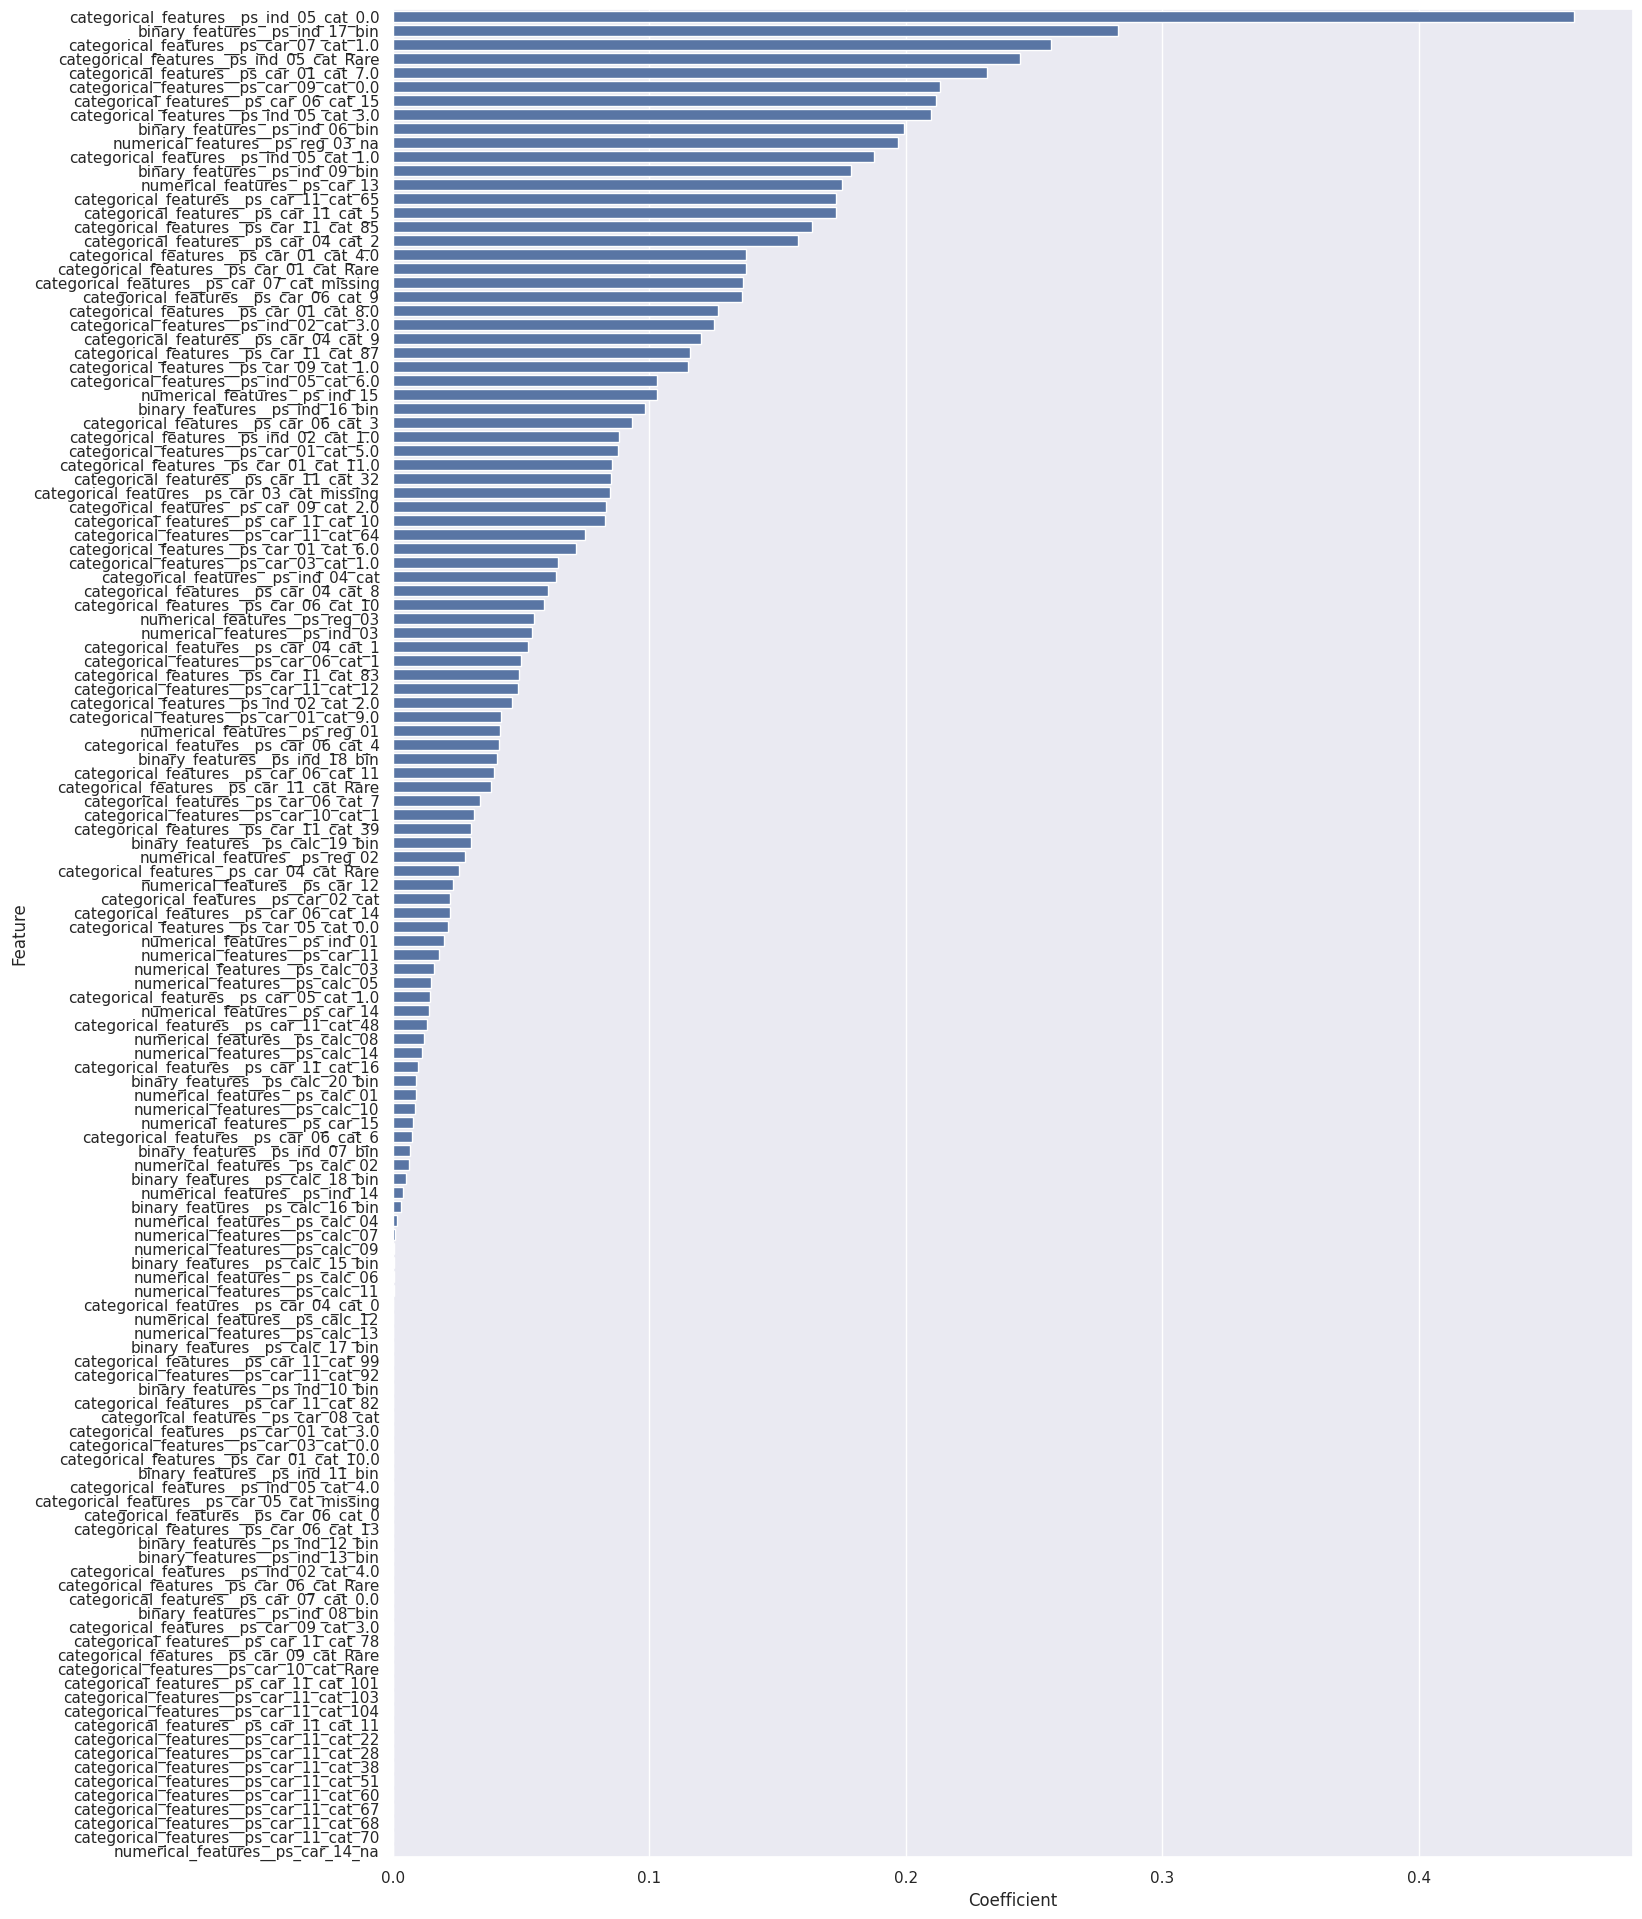

In [ ]:
plt.figure(figsize=(16,24))
sns.barplot(x='Coefficient',y='Feature',data=feature_importance_lr_complete_dataset,orient='h')

<Axes: xlabel='Coefficient'>

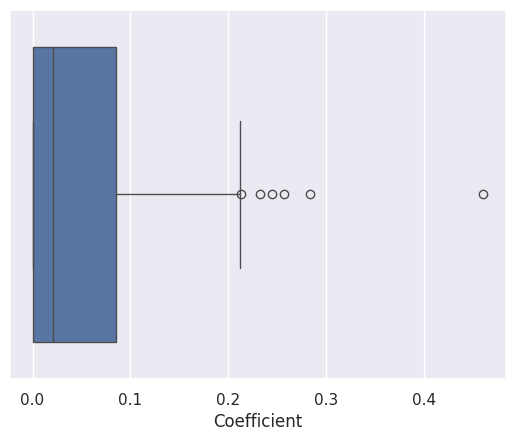

In [ ]:
#BoxPlot com valores dos coeficientes
sns.boxplot(data=feature_importance_lr_complete_dataset,x='Coefficient')


In [ ]:
resultados_complete_dataset=treinar_modelos_feature_selection(logistic_model,x_train_complete,y_train_complete,feature_importance_lr_complete_dataset,quantiles=[0,0.25,0.5,0.75])


Número de features selecionadas: 93





  0%|          | 0/10 [00:00<?, ?it/s]


 10%|█         | 1/10 [01:22<12:18, 82.06s/it]


 20%|██        | 2/10 [02:42<10:49, 81.20s/it]


 30%|███       | 3/10 [04:01<09:21, 80.15s/it]


 40%|████      | 4/10 [05:23<08:04, 80.67s/it]


 50%|█████     | 5/10 [06:59<07:12, 86.50s/it]


 60%|██████    | 6/10 [08:22<05:40, 85.22s/it]


 70%|███████   | 7/10 [09:24<03:53, 77.71s/it]


 80%|████████  | 8/10 [10:39<02:33, 76.71s/it]


 90%|█████████ | 9/10 [12:05<01:19, 79.66s/it]


100%|██████████| 10/10 [13:28<00:00, 80.86s/it]



Número de features selecionadas: 66





  0%|          | 0/10 [00:00<?, ?it/s]


 10%|█         | 1/10 [00:11<01:40, 11.11s/it]


 20%|██        | 2/10 [00:22<01:30, 11.27s/it]


 30%|███       | 3/10 [00:34<01:20, 11.44s/it]


 40%|████      | 4/10 [00:45<01:08, 11.39s/it]


 50%|█████     | 5/10 [00:57<00:58, 11.66s/it]


 60%|██████    | 6/10 [01:08<00:45, 11.35s/it]


 70%|███████   | 7/10 [01:19<00:34, 11.43s/it]


 80%|████████  | 8/10 [01:29<00:21, 10.95s/it]


 90%|█████████ | 9/10 [01:41<00:11, 11.28s/it]


100%|██████████| 10/10 [01:53<00:00, 11.32s/it]



Número de features selecionadas: 33





  0%|          | 0/10 [00:00<?, ?it/s]


 10%|█         | 1/10 [00:06<00:58,  6.45s/it]


 20%|██        | 2/10 [00:13<00:53,  6.65s/it]


 30%|███       | 3/10 [00:20<00:48,  6.88s/it]


 40%|████      | 4/10 [00:27<00:40,  6.80s/it]


 50%|█████     | 5/10 [00:33<00:33,  6.63s/it]


 60%|██████    | 6/10 [00:39<00:26,  6.58s/it]


 70%|███████   | 7/10 [00:47<00:20,  6.96s/it]


 80%|████████  | 8/10 [00:53<00:13,  6.73s/it]


 90%|█████████ | 9/10 [01:00<00:06,  6.70s/it]


100%|██████████| 10/10 [01:07<00:00,  6.73s/it]


Text(0, 0.5, 'ROC AUC')

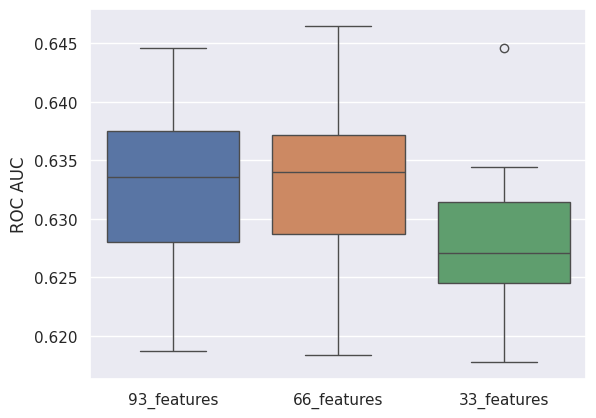

In [ ]:
resultados_complete_dataset=pd.DataFrame(resultados_complete_dataset)
sns.boxplot(resultados_complete_dataset)
plt.ylabel("ROC AUC")

In [ ]:
resultados_complete_dataset.describe()

,93_features,66_features,33_features
count,10.000000,10.000000,10.000000
mean,0.632523,0.633128,0.628038
std,0.007495,0.007812,0.007756
min,0.618691,0.618408,0.617787
25%,0.628043,0.628726,0.624545
50%,0.633529,0.633967,0.627099
75%,0.637472,0.637128,0.631443
max,0.644596,0.646473,0.644607


## Dataset com features selecionadas pela correlação

In [ ]:
#treinar modelo para  obter valores dos coeficientes
#modelo treinado com features selecionadas pela correlação
logistic_model.fit(x_train_corr,y_train_corr)

LogisticRegression(C=0.1, max_iter=1000, penalty='l1', random_state=0,
                   solver='saga')

In [ ]:
# Valores dos coeficientes da regressão
coefficients_selected_features_corr = logistic_model.coef_[0] #model

#criação de um dataframe com os valores dos coeficientes da regressão
feature_importance_lr_selected_features_corr = pd.DataFrame({
    'Feature': x_train_corr.columns,
    'Coefficient': coefficients_selected_features_corr})

#ordenar os coeficientes de acordo com os maiores valores absolutos
feature_importance_lr_selected_features_corr['Coefficient']=feature_importance_lr_selected_features_corr['Coefficient'].abs()
feature_importance_lr_selected_features_corr.sort_values(by='Coefficient',ascending=False,inplace=True)

feature_importance_lr_selected_features_corr.describe()

,Coefficient
count,108.000000
mean,0.066621
std,0.081700
min,0.000000
25%,0.000000
50%,0.040025
75%,0.103052
max,0.460377


<Axes: xlabel='Coefficient', ylabel='Feature'>

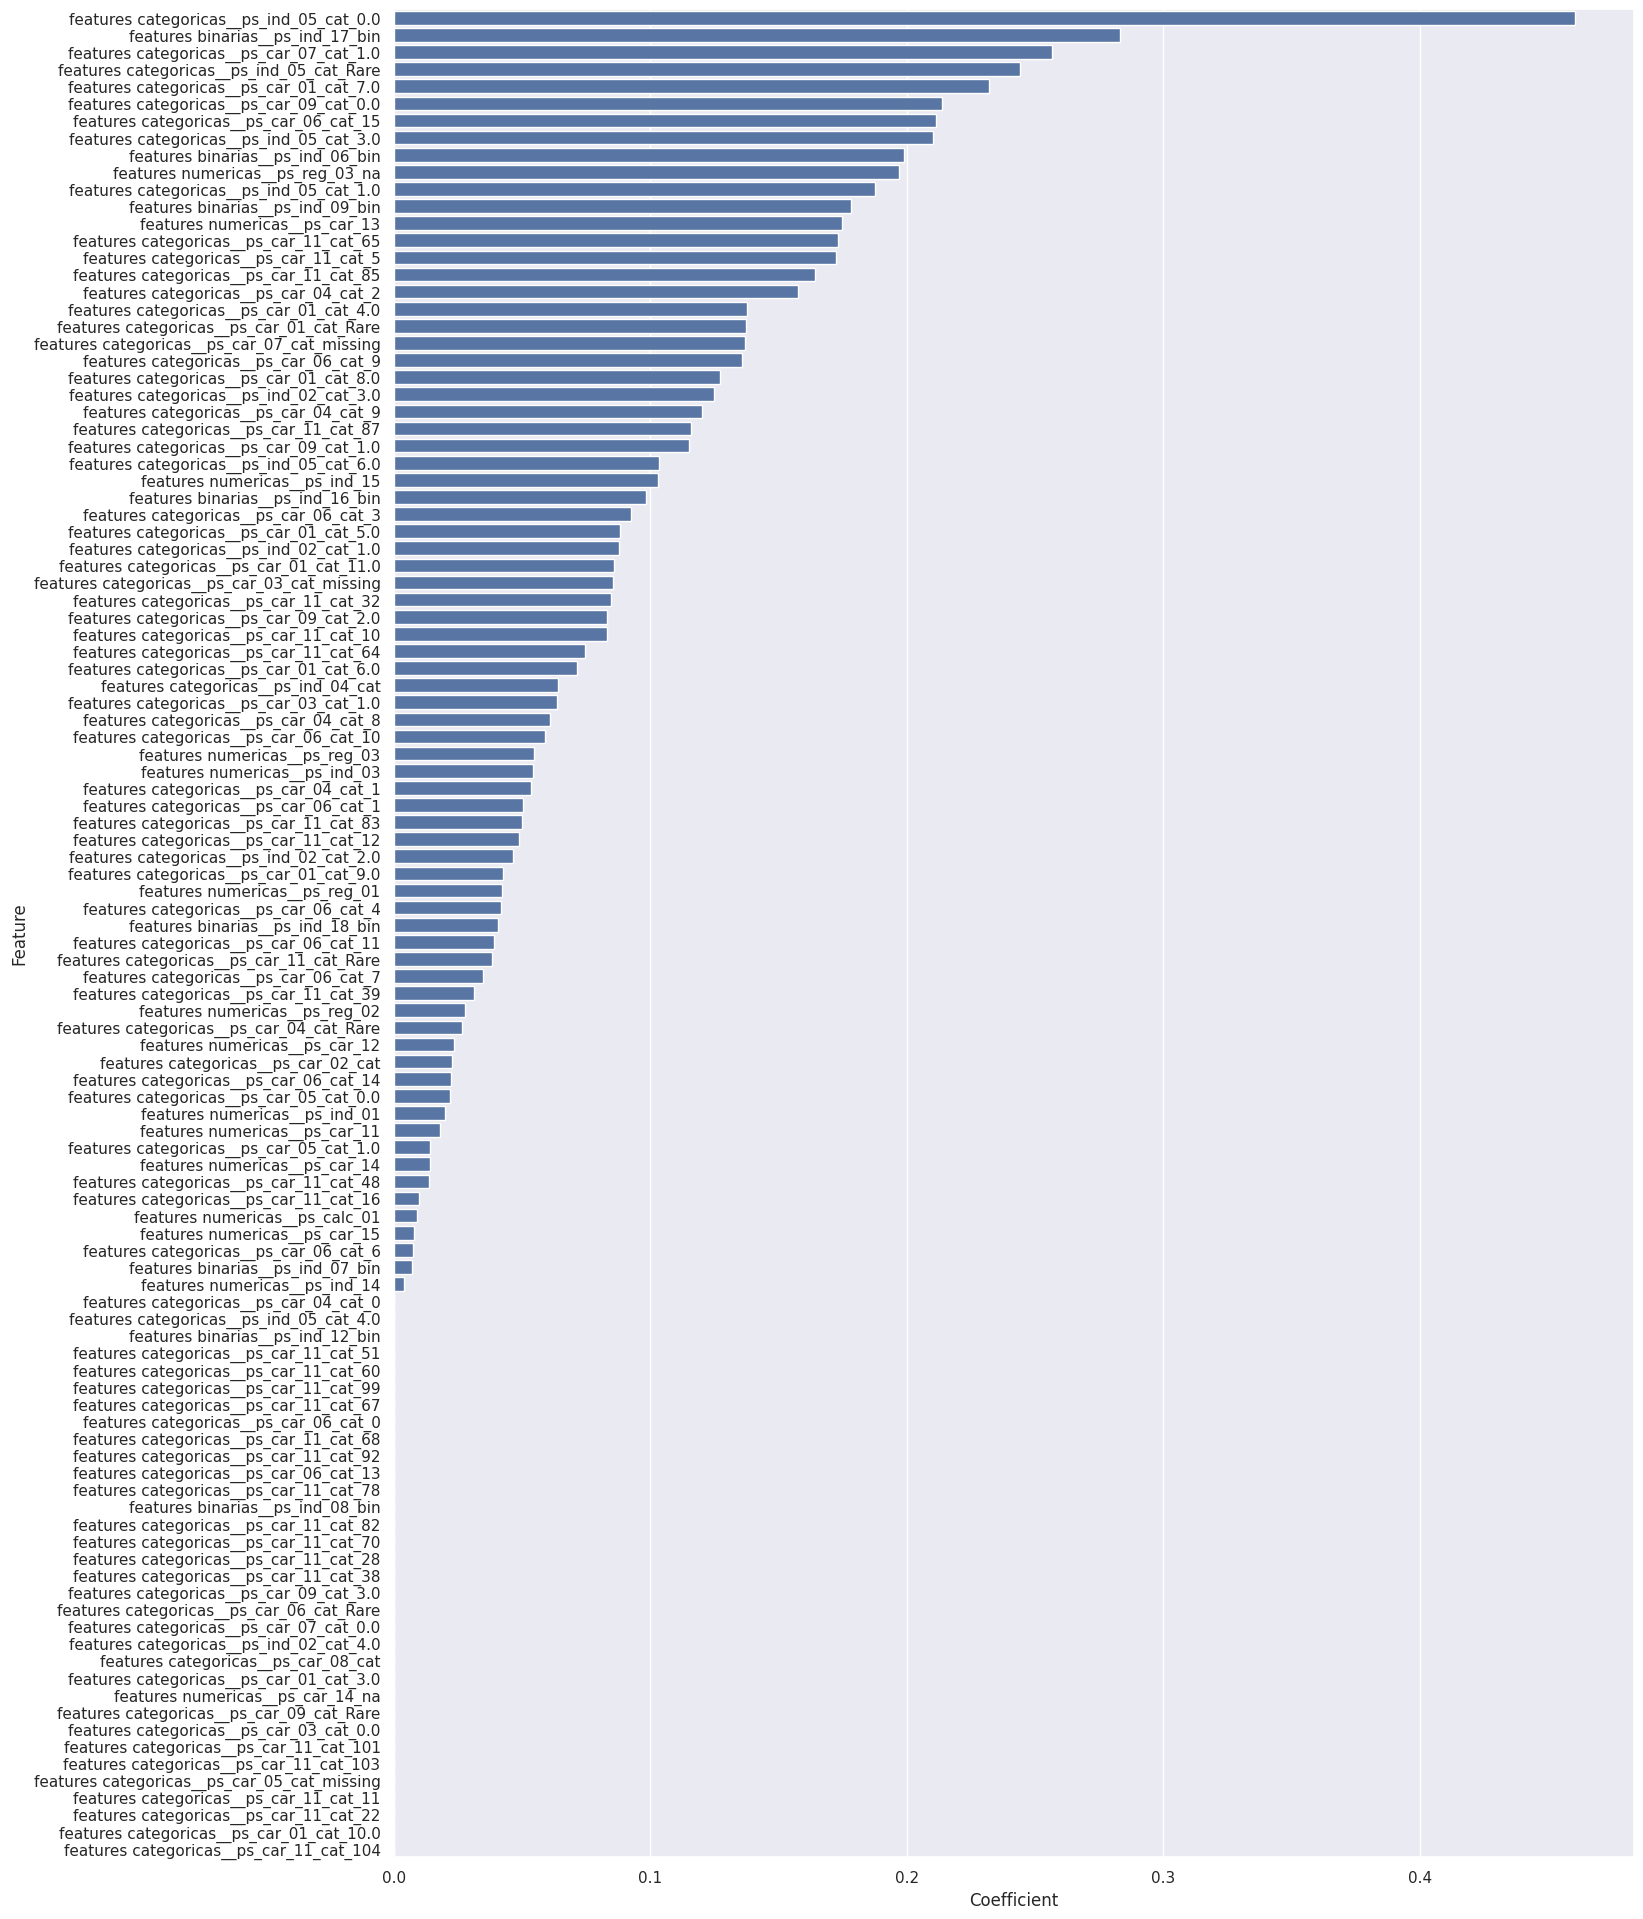

In [ ]:
plt.figure(figsize=(16,24))
sns.barplot(x='Coefficient',y='Feature',data=feature_importance_lr_selected_features_corr,orient='h')

<Axes: xlabel='Coefficient'>

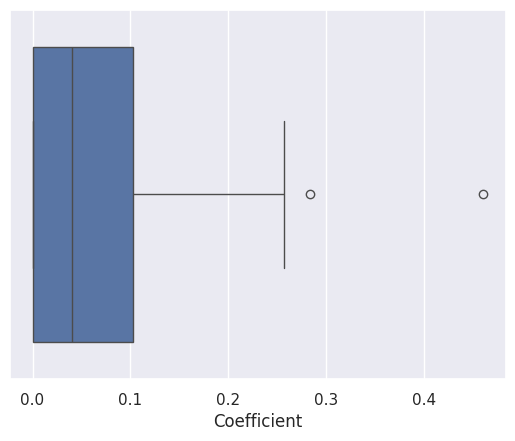

In [ ]:
#BoxPlot com valores dos coeficientes
sns.boxplot(data=feature_importance_lr_selected_features_corr,x='Coefficient')


In [ ]:
resultados_selected_features_corr=treinar_modelos_feature_selection(logistic_model,x_train_corr,y_train_corr,
                                                                    feature_importance_lr_selected_features_corr,quantiles=[0,0.25,0.5,0.75])


Número de features selecionadas: 77


100%|██████████| 10/10 [11:00<00:00, 66.05s/it]



Número de features selecionadas: 54


100%|██████████| 10/10 [01:39<00:00,  9.96s/it]



Número de features selecionadas: 27


100%|██████████| 10/10 [01:07<00:00,  6.78s/it]


Text(0, 0.5, 'ROC AUC')

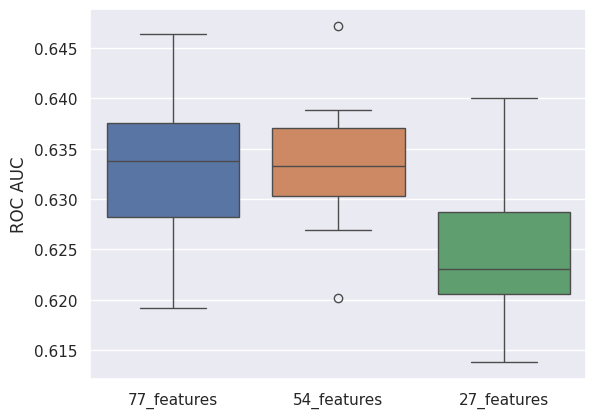

In [ ]:
resultados_selected_features_corr=pd.DataFrame(resultados_selected_features_corr)
sns.boxplot(resultados_selected_features_corr)
plt.ylabel("ROC AUC")

In [ ]:
resultados_selected_features_corr.describe()

,77_features,54_features,27_features
count,10.000000,10.000000,10.000000
mean,0.632940,0.633394,0.624440
std,0.007671,0.007269,0.007874
min,0.619223,0.620198,0.613834
25%,0.628175,0.630351,0.620561
50%,0.633749,0.633321,0.623094
75%,0.637571,0.637073,0.628690
max,0.646366,0.647209,0.639995


## Comparativo

Comparar os resultados obtidos obtidos com a regressão logistica treinada com diferentes datasets.



*   Três datasets vieram da seleção das features do dataset inicial completo
*   Outros três da seleção da features do dataset com as features previamente selecionadas através da correlação



In [ ]:
colunas=[column_name+'_lr_complete' for column_name in resultados_complete_dataset.columns]
resultados_complete_dataset.columns=colunas
resultados_complete_dataset

,93_features_lr_complete,66_features_lr_complete,66_features_lr_complete
0,0.633824,0.633877,0.624861
1,0.618691,0.618408,0.617787
2,0.638618,0.639600,0.632482
3,0.625048,0.626051,0.619284
4,0.626836,0.627204,0.624439
5,0.633235,0.634216,0.627294
6,0.634036,0.634058,0.626905
7,0.638685,0.638099,0.634390
8,0.631663,0.633293,0.628326
9,0.644596,0.646473,0.644607


In [ ]:
colunas=[column_name+'_lr_corr' for column_name in resultados_selected_features_corr.columns]
resultados_selected_features_corr.columns=colunas
resultados_selected_features_corr

,77_features_lr_corr,54_features_lr_corr,27_features_lr_corr
0,0.633873,0.633618,0.620862
1,0.619223,0.620198,0.615161
2,0.639094,0.638193,0.631789
3,0.625870,0.626877,0.613834
4,0.627014,0.629568,0.620461
5,0.633763,0.633025,0.622144
6,0.633735,0.633716,0.626781
7,0.638804,0.638843,0.629326
8,0.631658,0.632697,0.624044
9,0.646366,0.647209,0.639995


In [ ]:
#Concatenar os resultados em um único dataframe para facilitar a comparação
resultados_lr=pd.concat([resultados_complete_dataset,resultados_selected_features_corr],axis=1)

<Axes: >

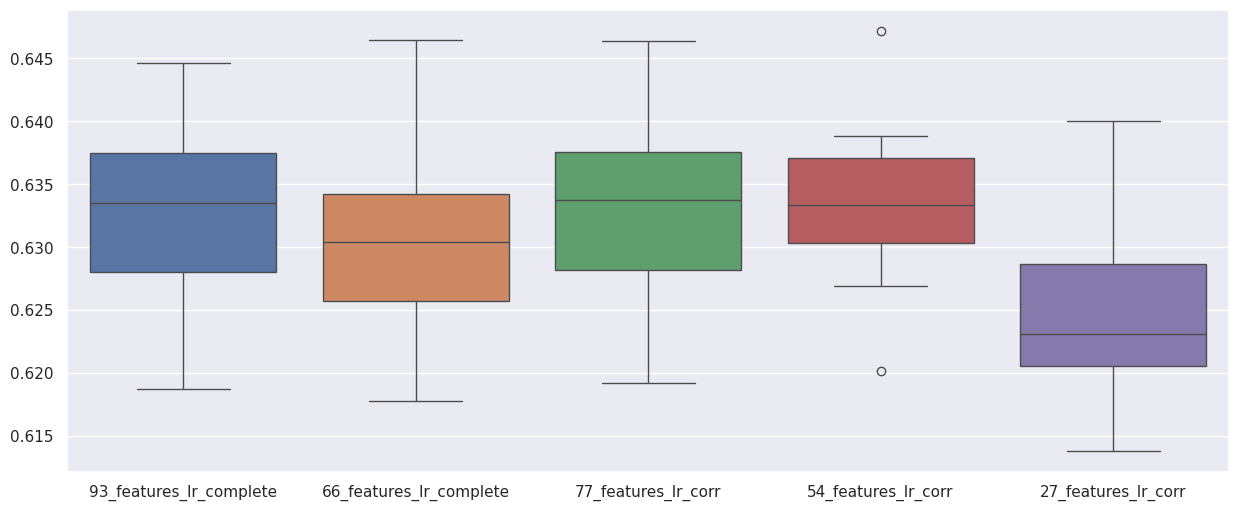

In [ ]:
plt.figure(figsize=(15,6))
sns.boxplot(resultados_lr)

In [ ]:
resultados_lr.describe()

,93_features_lr_complete,66_features_lr_complete,66_features_lr_complete,77_features_lr_corr,54_features_lr_corr,27_features_lr_corr
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.632523,0.633128,0.628038,0.632940,0.633394,0.624440
std,0.007495,0.007812,0.007756,0.007671,0.007269,0.007874
min,0.618691,0.618408,0.617787,0.619223,0.620198,0.613834
25%,0.628043,0.628726,0.624545,0.628175,0.630351,0.620561
50%,0.633529,0.633967,0.627099,0.633749,0.633321,0.623094
75%,0.637472,0.637128,0.631443,0.637571,0.637073,0.628690
max,0.644596,0.646473,0.644607,0.646366,0.647209,0.639995


Os melhores resultados com a regressão logśtica foram obtidos usando 54 features do dataset com as features selecionadas pela correlação

In [ ]:
#Salvar as melhores features para uso com a regrerssão logistica
best_features_logistic=feature_importance_lr_selected_features_corr.iloc[:54,0].to_list()
np.save('best_features_logistic.npy',best_features_logistic)

# LightGBM

## Dataset com todas as features iniciais




In [122]:
lgb_model = lgb.LGBMClassifier(importance_type='gain',n_estimators=1000)


In [123]:
#treinar modelo para  obter valores dos coeficientes
lgb_model.fit(x_train_complete,y_train_complete)

[LightGBM] [Info] Number of positive: 15186, number of negative: 401462
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.082229 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1388
[LightGBM] [Info] Number of data points in the train set: 416648, number of used features: 132
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036448 -> initscore=-3.274739
[LightGBM] [Info] Start training from score -3.274739


LGBMClassifier(importance_type='gain', n_estimators=1000)

In [134]:
feature_importance_lgb_complete_dataset = lgb_model.feature_importances_
#criação de dataframe com as feature importances
feature_importance_lgb_complete_dataset=pd.DataFrame({'Feature':x_train_complete.columns,'Feature Importance':feature_importance_lgb_complete_dataset})
feature_importance_lgb_complete_dataset=feature_importance_lgb_complete_dataset.sort_values(by='Feature Importance',ascending=False)

<Axes: xlabel='Feature Importance', ylabel='Feature'>

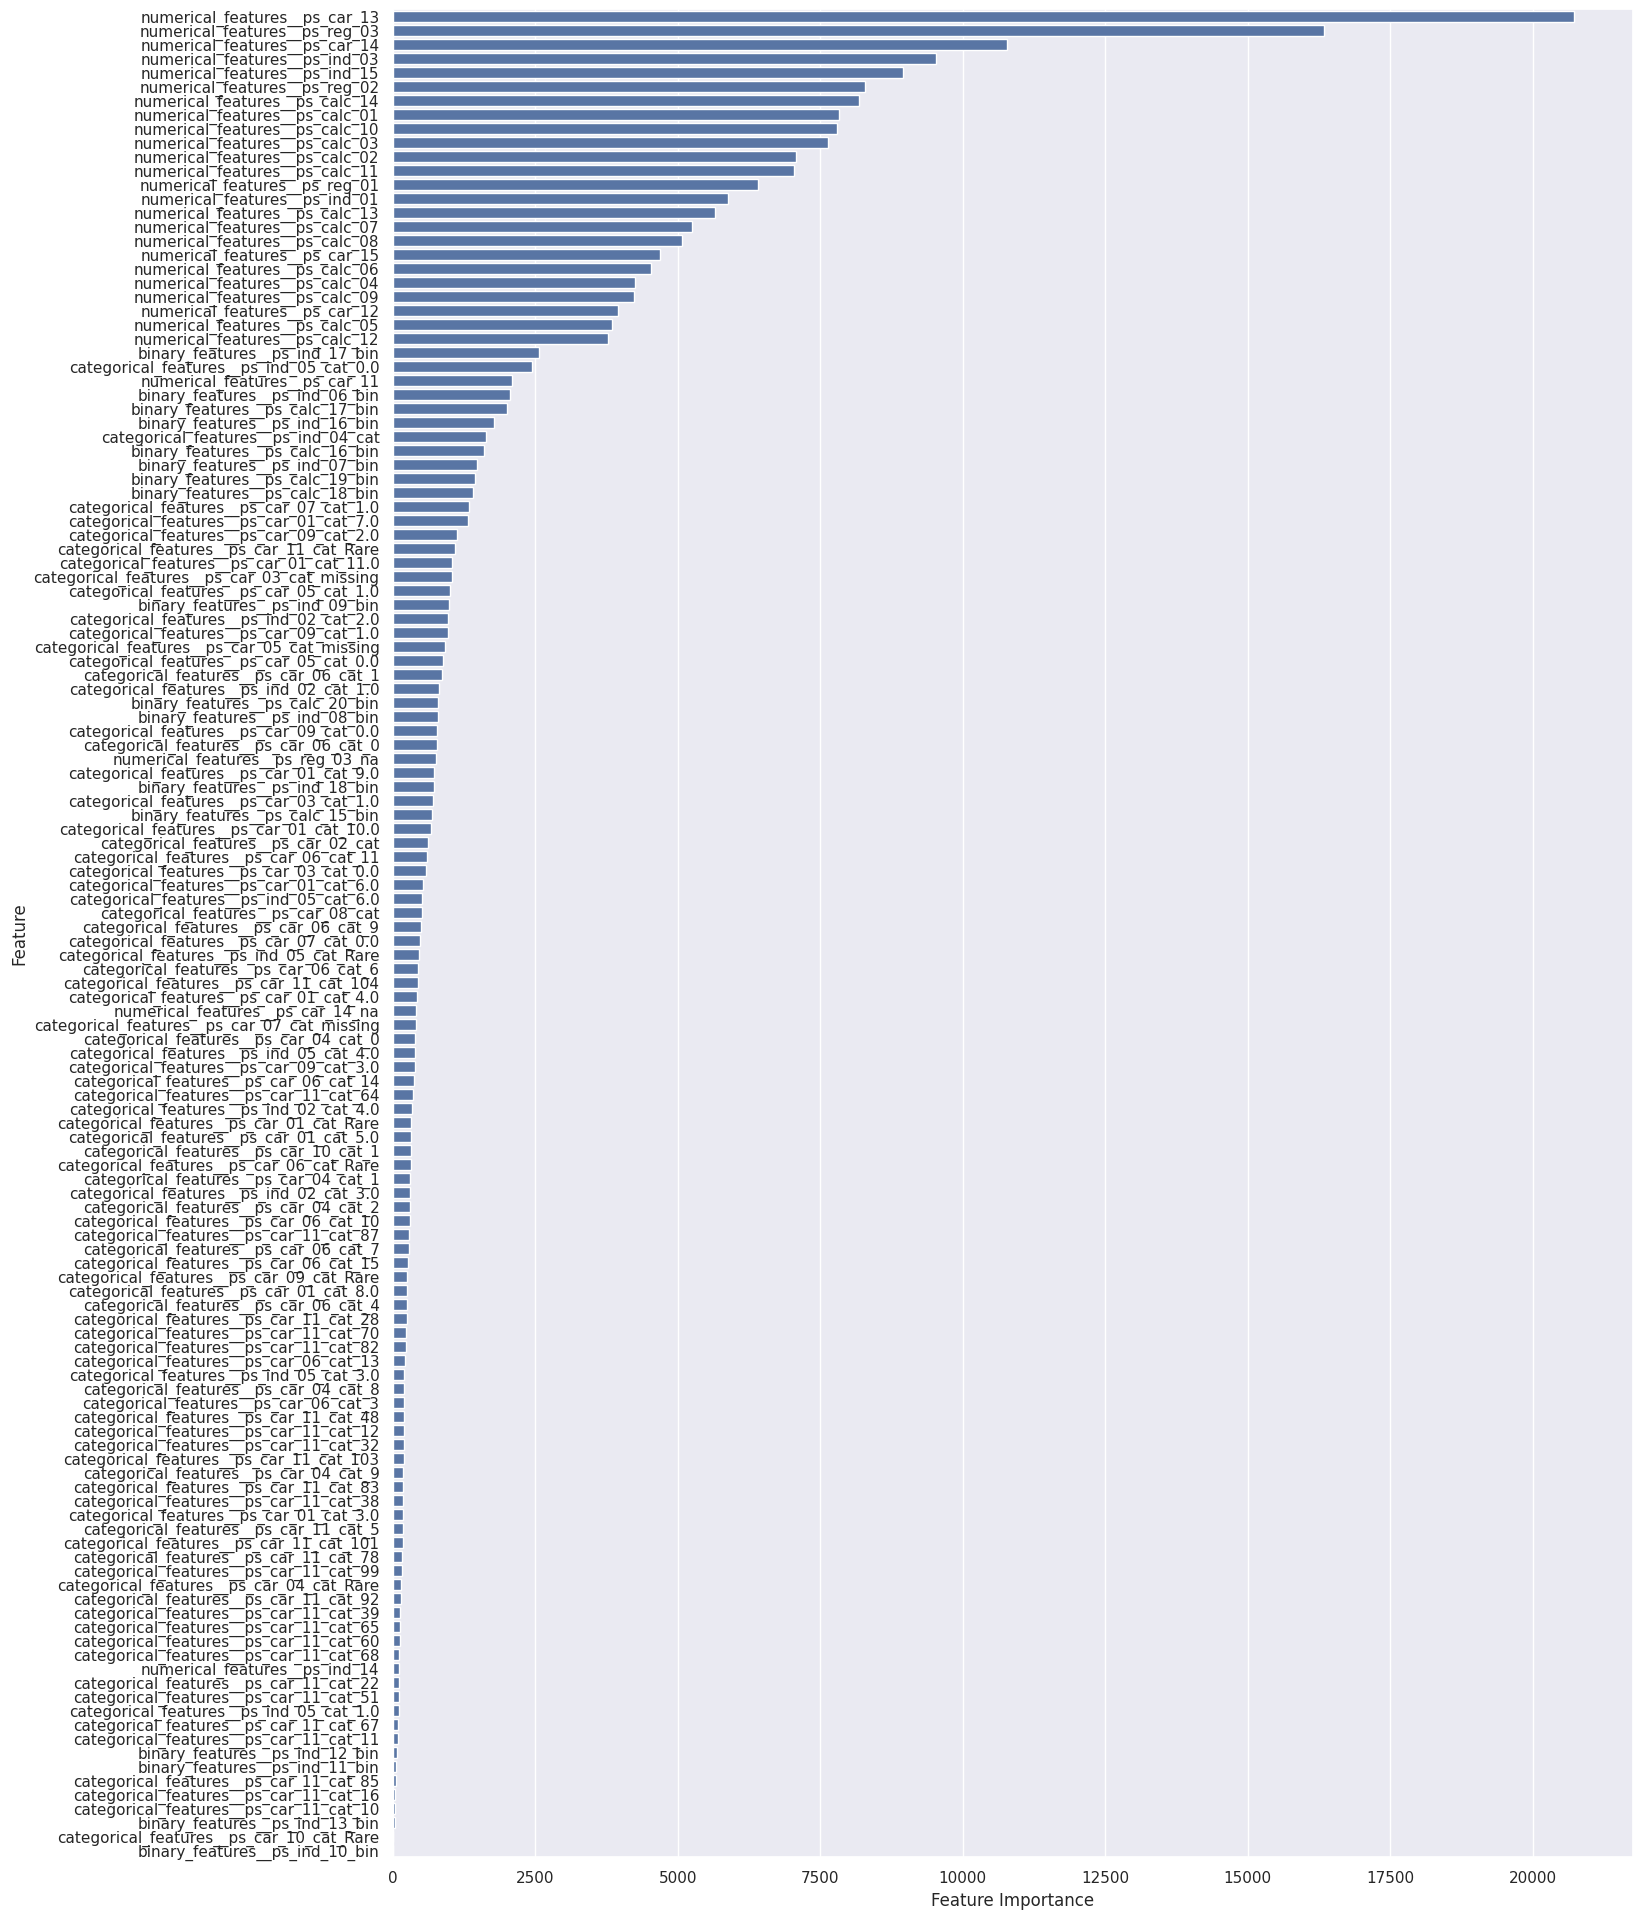

In [135]:
plt.figure(figsize=(16,24))
sns.barplot(x='Feature Importance',y='Feature',data=feature_importance_lgb_complete_dataset,orient='h')

<Axes: xlabel='Feature Importance'>

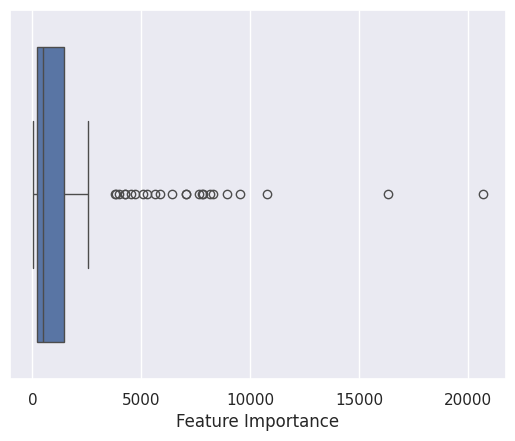

In [137]:
#BoxPlot com valores das feature imnportances
sns.boxplot(data=feature_importance_lgb_complete_dataset,x='Feature Importance')


In [138]:
resultados_lgb_complete_dataset=treinar_modelos_feature_selection(model_lgb,x_train_complete,y_train_complete,feature_importance_lgb_complete_dataset,feature_importance_column='Feature Importance')


Número de features selecionadas: 131


  0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 13667, number of negative: 361316
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.125296 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1383
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274769
[LightGBM] [Info] Start training from score -3.274769


 10%|█         | 1/10 [00:21<03:15, 21.68s/it]

[LightGBM] [Info] Number of positive: 13667, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.066184 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1377
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274769
[LightGBM] [Info] Start training from score -3.274769


 20%|██        | 2/10 [00:39<02:33, 19.16s/it]

[LightGBM] [Info] Number of positive: 13667, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.065243 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1381
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274769
[LightGBM] [Info] Start training from score -3.274769


 30%|███       | 3/10 [00:53<02:00, 17.16s/it]

[LightGBM] [Info] Number of positive: 13667, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.059206 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1383
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274769
[LightGBM] [Info] Start training from score -3.274769


 40%|████      | 4/10 [01:08<01:36, 16.16s/it]

[LightGBM] [Info] Number of positive: 13667, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.091972 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1380
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274769
[LightGBM] [Info] Start training from score -3.274769


 50%|█████     | 5/10 [01:23<01:18, 15.62s/it]

[LightGBM] [Info] Number of positive: 13667, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.072636 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1387
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274769
[LightGBM] [Info] Start training from score -3.274769


 60%|██████    | 6/10 [01:39<01:03, 15.81s/it]

[LightGBM] [Info] Number of positive: 13668, number of negative: 361315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.064348 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1383
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036450 -> initscore=-3.274693
[LightGBM] [Info] Start training from score -3.274693


 70%|███████   | 7/10 [01:54<00:46, 15.61s/it]

[LightGBM] [Info] Number of positive: 13668, number of negative: 361315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.072643 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1382
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036450 -> initscore=-3.274693
[LightGBM] [Info] Start training from score -3.274693


 80%|████████  | 8/10 [02:10<00:31, 15.66s/it]

[LightGBM] [Info] Number of positive: 13668, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.079923 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1382
[LightGBM] [Info] Number of data points in the train set: 374984, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036450 -> initscore=-3.274696
[LightGBM] [Info] Start training from score -3.274696


 90%|█████████ | 9/10 [02:25<00:15, 15.53s/it]

[LightGBM] [Info] Number of positive: 13668, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.068669 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1376
[LightGBM] [Info] Number of data points in the train set: 374984, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036450 -> initscore=-3.274696
[LightGBM] [Info] Start training from score -3.274696


100%|██████████| 10/10 [02:41<00:00, 16.14s/it]



Número de features selecionadas: 99


  0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 13667, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.066085 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1315
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274769
[LightGBM] [Info] Start training from score -3.274769


 10%|█         | 1/10 [00:16<02:24, 16.11s/it]

[LightGBM] [Info] Number of positive: 13667, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.063452 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1309
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274769
[LightGBM] [Info] Start training from score -3.274769


 20%|██        | 2/10 [00:31<02:04, 15.59s/it]

[LightGBM] [Info] Number of positive: 13667, number of negative: 361316
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.096105 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1313
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274769
[LightGBM] [Info] Start training from score -3.274769


 30%|███       | 3/10 [00:49<01:58, 16.96s/it]

[LightGBM] [Info] Number of positive: 13667, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.053905 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1315
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274769
[LightGBM] [Info] Start training from score -3.274769


 40%|████      | 4/10 [01:04<01:35, 15.91s/it]

[LightGBM] [Info] Number of positive: 13667, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.071155 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1312
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274769
[LightGBM] [Info] Start training from score -3.274769


 50%|█████     | 5/10 [01:21<01:21, 16.31s/it]

[LightGBM] [Info] Number of positive: 13667, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.078154 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1319
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274769
[LightGBM] [Info] Start training from score -3.274769


 60%|██████    | 6/10 [01:35<01:03, 15.76s/it]

[LightGBM] [Info] Number of positive: 13668, number of negative: 361315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.056531 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1315
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036450 -> initscore=-3.274693
[LightGBM] [Info] Start training from score -3.274693


 70%|███████   | 7/10 [01:48<00:44, 14.77s/it]

[LightGBM] [Info] Number of positive: 13668, number of negative: 361315
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.096636 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1314
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036450 -> initscore=-3.274693
[LightGBM] [Info] Start training from score -3.274693


 80%|████████  | 8/10 [02:06<00:31, 15.60s/it]

[LightGBM] [Info] Number of positive: 13668, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.059496 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1315
[LightGBM] [Info] Number of data points in the train set: 374984, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036450 -> initscore=-3.274696
[LightGBM] [Info] Start training from score -3.274696


 90%|█████████ | 9/10 [02:19<00:15, 15.04s/it]

[LightGBM] [Info] Number of positive: 13668, number of negative: 361316
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.142241 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1308
[LightGBM] [Info] Number of data points in the train set: 374984, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036450 -> initscore=-3.274696
[LightGBM] [Info] Start training from score -3.274696


100%|██████████| 10/10 [02:38<00:00, 15.89s/it]



Número de features selecionadas: 66


  0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 13667, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044090 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1249
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 66
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274769
[LightGBM] [Info] Start training from score -3.274769


 10%|█         | 1/10 [00:14<02:08, 14.32s/it]

[LightGBM] [Info] Number of positive: 13667, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.051612 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1243
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 66
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274769
[LightGBM] [Info] Start training from score -3.274769


 20%|██        | 2/10 [00:28<01:53, 14.21s/it]

[LightGBM] [Info] Number of positive: 13667, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.047265 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1247
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 66
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274769
[LightGBM] [Info] Start training from score -3.274769


 30%|███       | 3/10 [00:41<01:36, 13.84s/it]

[LightGBM] [Info] Number of positive: 13667, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.051982 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1249
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 66
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274769
[LightGBM] [Info] Start training from score -3.274769


 40%|████      | 4/10 [00:54<01:20, 13.42s/it]

[LightGBM] [Info] Number of positive: 13667, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049803 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1246
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 66
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274769
[LightGBM] [Info] Start training from score -3.274769


 50%|█████     | 5/10 [01:07<01:06, 13.28s/it]

[LightGBM] [Info] Number of positive: 13667, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044845 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1253
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 66
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274769
[LightGBM] [Info] Start training from score -3.274769


 60%|██████    | 6/10 [01:19<00:51, 12.83s/it]

[LightGBM] [Info] Number of positive: 13668, number of negative: 361315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048746 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1249
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 66
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036450 -> initscore=-3.274693
[LightGBM] [Info] Start training from score -3.274693


 70%|███████   | 7/10 [01:31<00:37, 12.65s/it]

[LightGBM] [Info] Number of positive: 13668, number of negative: 361315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044292 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1248
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 66
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036450 -> initscore=-3.274693
[LightGBM] [Info] Start training from score -3.274693


 80%|████████  | 8/10 [01:44<00:25, 12.57s/it]

[LightGBM] [Info] Number of positive: 13668, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044902 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1249
[LightGBM] [Info] Number of data points in the train set: 374984, number of used features: 66
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036450 -> initscore=-3.274696
[LightGBM] [Info] Start training from score -3.274696


 90%|█████████ | 9/10 [01:57<00:12, 12.70s/it]

[LightGBM] [Info] Number of positive: 13668, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041918 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1242
[LightGBM] [Info] Number of data points in the train set: 374984, number of used features: 66
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036450 -> initscore=-3.274696
[LightGBM] [Info] Start training from score -3.274696


100%|██████████| 10/10 [02:10<00:00, 13.02s/it]



Número de features selecionadas: 33


  0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 13667, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008596 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1183
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274769
[LightGBM] [Info] Start training from score -3.274769


 10%|█         | 1/10 [00:10<01:34, 10.52s/it]

[LightGBM] [Info] Number of positive: 13667, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008263 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1177
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274769
[LightGBM] [Info] Start training from score -3.274769


 20%|██        | 2/10 [00:20<01:22, 10.26s/it]

[LightGBM] [Info] Number of positive: 13667, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010717 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1181
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274769
[LightGBM] [Info] Start training from score -3.274769


 30%|███       | 3/10 [00:30<01:12, 10.29s/it]

[LightGBM] [Info] Number of positive: 13667, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008599 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1183
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274769
[LightGBM] [Info] Start training from score -3.274769


 40%|████      | 4/10 [00:41<01:02, 10.40s/it]

[LightGBM] [Info] Number of positive: 13667, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009079 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1180
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274769
[LightGBM] [Info] Start training from score -3.274769


 50%|█████     | 5/10 [00:52<00:52, 10.45s/it]

[LightGBM] [Info] Number of positive: 13667, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008569 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1187
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274769
[LightGBM] [Info] Start training from score -3.274769


 60%|██████    | 6/10 [01:03<00:42, 10.67s/it]

[LightGBM] [Info] Number of positive: 13668, number of negative: 361315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010308 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1183
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036450 -> initscore=-3.274693
[LightGBM] [Info] Start training from score -3.274693


 70%|███████   | 7/10 [01:15<00:33, 11.15s/it]

[LightGBM] [Info] Number of positive: 13668, number of negative: 361315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008706 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1182
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036450 -> initscore=-3.274693
[LightGBM] [Info] Start training from score -3.274693


 80%|████████  | 8/10 [01:25<00:22, 11.01s/it]

[LightGBM] [Info] Number of positive: 13668, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009282 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1183
[LightGBM] [Info] Number of data points in the train set: 374984, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036450 -> initscore=-3.274696
[LightGBM] [Info] Start training from score -3.274696


 90%|█████████ | 9/10 [01:37<00:11, 11.04s/it]

[LightGBM] [Info] Number of positive: 13668, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008202 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1176
[LightGBM] [Info] Number of data points in the train set: 374984, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036450 -> initscore=-3.274696
[LightGBM] [Info] Start training from score -3.274696


100%|██████████| 10/10 [01:48<00:00, 10.80s/it]


Text(0, 0.5, 'ROC AUC')

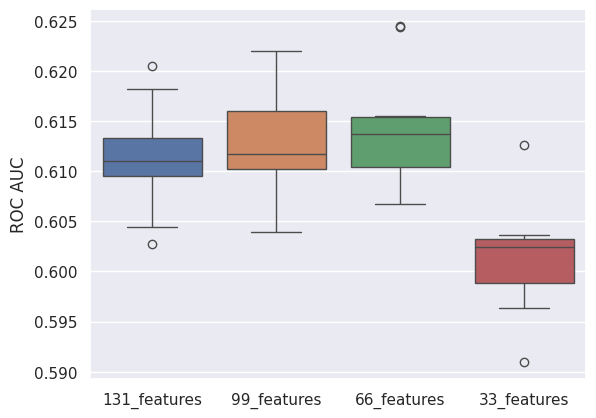

In [143]:
resultados_lgb_complete_dataset=pd.DataFrame(resultados_lgb_complete_dataset)
sns.boxplot(resultados_lgb_complete_dataset)
plt.ylabel("ROC AUC")

In [140]:
resultados_lgb_complete_dataset.describe()

,131_features,99_features,66_features,33_features
count,10.000000,10.000000,10.000000,10.000000
mean,0.611295,0.612932,0.614196,0.601349
std,0.005429,0.005843,0.006175,0.005636
min,0.602761,0.603904,0.606681,0.590978
25%,0.609493,0.610179,0.610409,0.598850
50%,0.611008,0.611751,0.613755,0.602454
75%,0.613324,0.615966,0.615378,0.603267
max,0.620532,0.622012,0.624508,0.612639


 ## Dataset com features selecionadas pela correlação

In [144]:
#treinar modelo para  obter valores dos coeficientes
lgb_model.fit(x_train_corr,y_train_corr)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15186, number of negative: 401462
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.055018 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1189
[LightGBM] [Info] Number of data points in the train set: 416648, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036448 -> initscore=-3.274739
[LightGBM] [Info] Start training from score -3.274739


LGBMClassifier(importance_type='gain', n_estimators=1000)

In [146]:
feature_importance_lgb_selected_features_corr = lgb_model.feature_importances_
#criação de dataframe com as feature importances
feature_importance_lgb_selected_features_corr=pd.DataFrame({'Feature':x_train_corr.columns,'Feature Importance':feature_importance_lgb_selected_features_corr})
feature_importance_lgb_selected_features_corr=feature_importance_lgb_selected_features_corr.sort_values(by='Feature Importance',ascending=False)

<Axes: xlabel='Feature Importance', ylabel='Feature'>

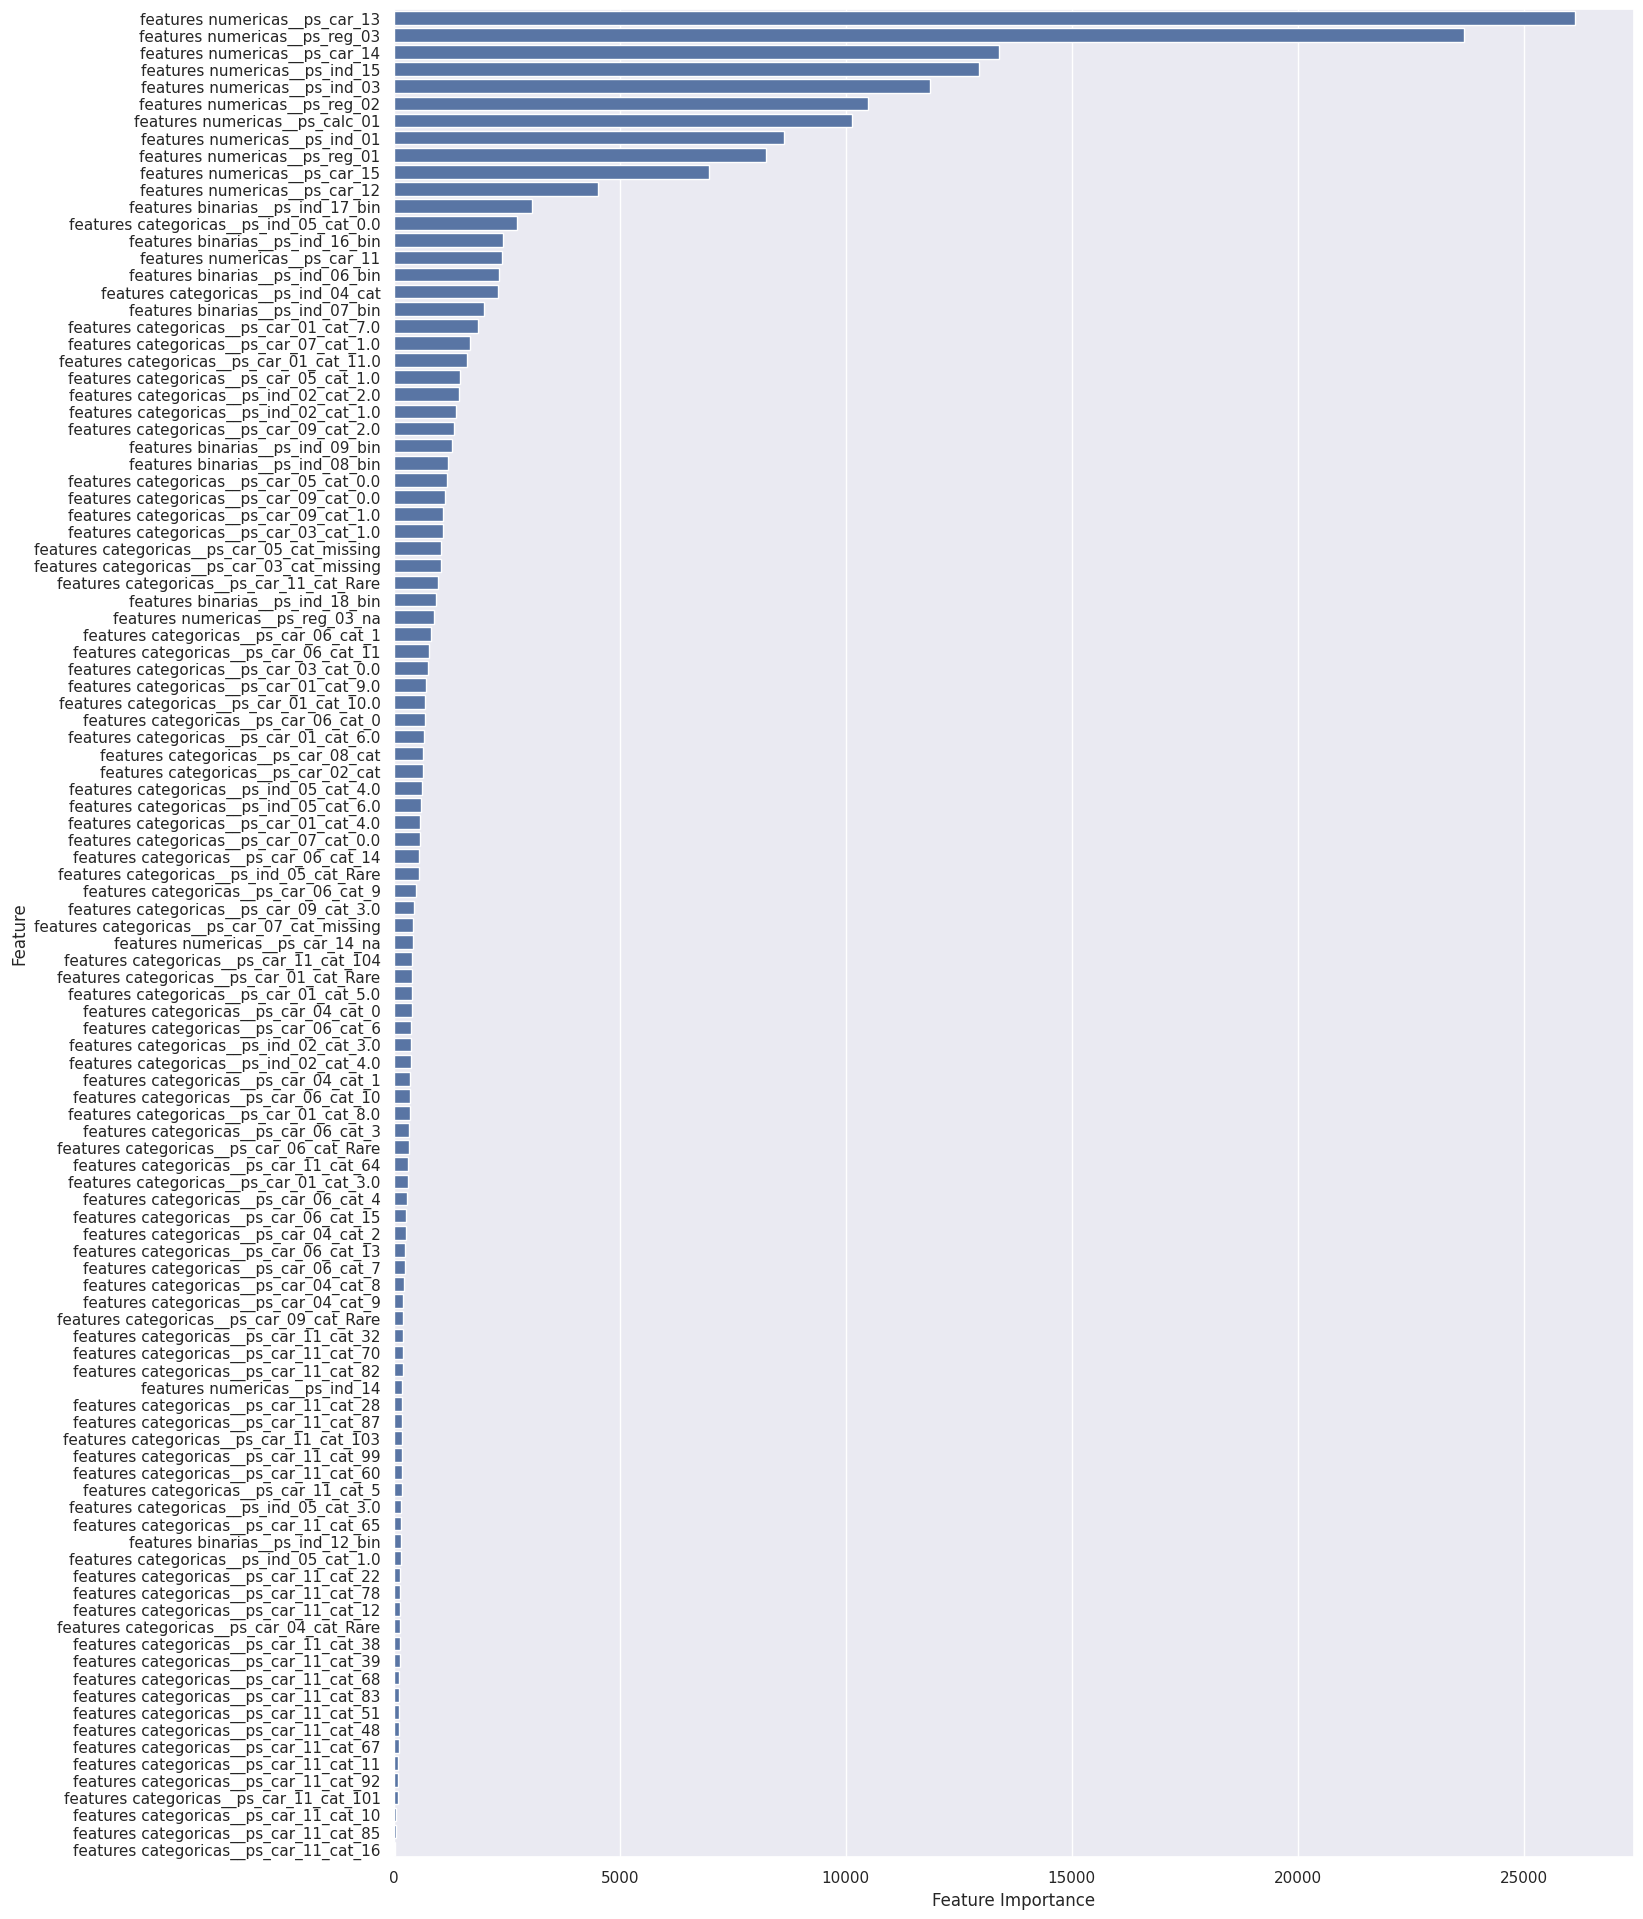

In [148]:
plt.figure(figsize=(16,24))
sns.barplot(x='Feature Importance',y='Feature',data=feature_importance_lgb_selected_features_corr,orient='h')

<Axes: xlabel='Feature Importance'>

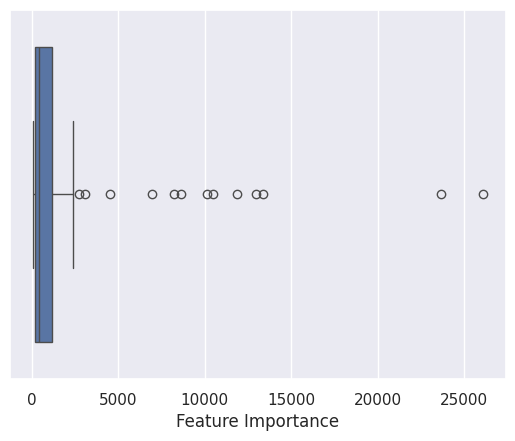

In [149]:
#BoxPlot com valores das feature imnportances
sns.boxplot(data=feature_importance_lgb_selected_features_corr,x='Feature Importance')


In [150]:
resultados_lgb_selected_features_corr=treinar_modelos_feature_selection(model_lgb,x_train_corr,y_train_corr,
                                                                        feature_importance_lgb_selected_features_corr,feature_importance_column='Feature Importance')


Número de features selecionadas: 107


  0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 13667, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.046674 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1185
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 107
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274769
[LightGBM] [Info] Start training from score -3.274769


 10%|█         | 1/10 [00:10<01:31, 10.22s/it]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 13667, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049987 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1179
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 107
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274769
[LightGBM] [Info] Start training from score -3.274769


 20%|██        | 2/10 [00:20<01:22, 10.31s/it]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 13667, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.047990 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1184
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 107
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274769
[LightGBM] [Info] Start training from score -3.274769


 30%|███       | 3/10 [00:31<01:15, 10.79s/it]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 13667, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.047087 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1186
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 107
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274769
[LightGBM] [Info] Start training from score -3.274769


 40%|████      | 4/10 [00:43<01:07, 11.19s/it]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 13667, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.053777 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1184
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 107
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274769
[LightGBM] [Info] Start training from score -3.274769


 50%|█████     | 5/10 [00:55<00:57, 11.41s/it]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 13667, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.052192 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1189
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 107
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274769
[LightGBM] [Info] Start training from score -3.274769


 60%|██████    | 6/10 [01:07<00:45, 11.49s/it]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 13668, number of negative: 361315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.051126 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1184
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 107
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036450 -> initscore=-3.274693
[LightGBM] [Info] Start training from score -3.274693


 70%|███████   | 7/10 [01:18<00:34, 11.58s/it]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 13668, number of negative: 361315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.050340 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1183
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 107
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036450 -> initscore=-3.274693
[LightGBM] [Info] Start training from score -3.274693


 80%|████████  | 8/10 [01:30<00:23, 11.71s/it]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 13668, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.059554 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1183
[LightGBM] [Info] Number of data points in the train set: 374984, number of used features: 107
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036450 -> initscore=-3.274696
[LightGBM] [Info] Start training from score -3.274696


 90%|█████████ | 9/10 [01:42<00:11, 11.74s/it]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 13668, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.045195 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1179
[LightGBM] [Info] Number of data points in the train set: 374984, number of used features: 107
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036450 -> initscore=-3.274696
[LightGBM] [Info] Start training from score -3.274696


100%|██████████| 10/10 [01:53<00:00, 11.38s/it]



Número de features selecionadas: 81


  0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 13667, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.057355 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1133
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 81
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274769
[LightGBM] [Info] Start training from score -3.274769


 10%|█         | 1/10 [00:11<01:40, 11.20s/it]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 13667, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.059599 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1127
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 81
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274769
[LightGBM] [Info] Start training from score -3.274769


 20%|██        | 2/10 [00:22<01:31, 11.41s/it]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 13667, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.059401 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1132
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 81
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274769
[LightGBM] [Info] Start training from score -3.274769


 30%|███       | 3/10 [00:32<01:13, 10.55s/it]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 13667, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042327 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1134
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 81
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274769
[LightGBM] [Info] Start training from score -3.274769


 40%|████      | 4/10 [00:42<01:03, 10.55s/it]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 13667, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.055296 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1132
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 81
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274769
[LightGBM] [Info] Start training from score -3.274769


 50%|█████     | 5/10 [00:54<00:54, 10.98s/it]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 13667, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.045612 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1137
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 81
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274769
[LightGBM] [Info] Start training from score -3.274769


 60%|██████    | 6/10 [01:05<00:43, 10.99s/it]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 13668, number of negative: 361315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048123 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1132
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 81
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036450 -> initscore=-3.274693
[LightGBM] [Info] Start training from score -3.274693


 70%|███████   | 7/10 [01:16<00:32, 10.91s/it]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 13668, number of negative: 361315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044251 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1131
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 81
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036450 -> initscore=-3.274693
[LightGBM] [Info] Start training from score -3.274693


 80%|████████  | 8/10 [01:26<00:21, 10.76s/it]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 13668, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.045341 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1131
[LightGBM] [Info] Number of data points in the train set: 374984, number of used features: 81
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036450 -> initscore=-3.274696
[LightGBM] [Info] Start training from score -3.274696


 90%|█████████ | 9/10 [01:37<00:10, 10.79s/it]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 13668, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.051133 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1127
[LightGBM] [Info] Number of data points in the train set: 374984, number of used features: 81
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036450 -> initscore=-3.274696
[LightGBM] [Info] Start training from score -3.274696


100%|██████████| 10/10 [01:48<00:00, 10.85s/it]



Número de features selecionadas: 54


  0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 13667, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034493 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1075
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274769
[LightGBM] [Info] Start training from score -3.274769


 10%|█         | 1/10 [00:09<01:26,  9.64s/it]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 13667, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037457 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1069
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274769
[LightGBM] [Info] Start training from score -3.274769


 20%|██        | 2/10 [00:19<01:18,  9.85s/it]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 13667, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035111 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1074
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274769
[LightGBM] [Info] Start training from score -3.274769


 30%|███       | 3/10 [00:29<01:09,  9.99s/it]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 13667, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031232 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1076
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274769
[LightGBM] [Info] Start training from score -3.274769


 40%|████      | 4/10 [00:39<00:59,  9.94s/it]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 13667, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030799 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1074
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274769
[LightGBM] [Info] Start training from score -3.274769


 50%|█████     | 5/10 [00:49<00:49,  9.88s/it]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 13667, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035153 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1079
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274769
[LightGBM] [Info] Start training from score -3.274769


 60%|██████    | 6/10 [00:59<00:39,  9.92s/it]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 13668, number of negative: 361315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036081 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1074
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036450 -> initscore=-3.274693
[LightGBM] [Info] Start training from score -3.274693


 70%|███████   | 7/10 [01:09<00:29,  9.97s/it]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 13668, number of negative: 361315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034146 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1073
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036450 -> initscore=-3.274693
[LightGBM] [Info] Start training from score -3.274693


 80%|████████  | 8/10 [01:19<00:19,  9.99s/it]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 13668, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031074 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1074
[LightGBM] [Info] Number of data points in the train set: 374984, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036450 -> initscore=-3.274696
[LightGBM] [Info] Start training from score -3.274696


 90%|█████████ | 9/10 [01:30<00:10, 10.19s/it]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 13668, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037154 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1069
[LightGBM] [Info] Number of data points in the train set: 374984, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036450 -> initscore=-3.274696
[LightGBM] [Info] Start training from score -3.274696


100%|██████████| 10/10 [01:40<00:00, 10.09s/it]



Número de features selecionadas: 27


  0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 13667, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023932 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1021
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274769
[LightGBM] [Info] Start training from score -3.274769


 10%|█         | 1/10 [00:10<01:35, 10.61s/it]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 13667, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020400 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1015
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274769
[LightGBM] [Info] Start training from score -3.274769


 20%|██        | 2/10 [00:20<01:21, 10.21s/it]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 13667, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024356 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274769
[LightGBM] [Info] Start training from score -3.274769


 30%|███       | 3/10 [00:30<01:09,  9.96s/it]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 13667, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021883 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274769
[LightGBM] [Info] Start training from score -3.274769


 40%|████      | 4/10 [00:39<00:57,  9.64s/it]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 13667, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026090 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274769
[LightGBM] [Info] Start training from score -3.274769


 50%|█████     | 5/10 [00:49<00:48,  9.69s/it]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 13667, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022525 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1025
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274769
[LightGBM] [Info] Start training from score -3.274769


 60%|██████    | 6/10 [00:58<00:38,  9.72s/it]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 13668, number of negative: 361315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023004 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036450 -> initscore=-3.274693
[LightGBM] [Info] Start training from score -3.274693


 70%|███████   | 7/10 [01:09<00:29,  9.87s/it]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 13668, number of negative: 361315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024951 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1019
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036450 -> initscore=-3.274693
[LightGBM] [Info] Start training from score -3.274693


 80%|████████  | 8/10 [01:18<00:19,  9.82s/it]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 13668, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022138 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 374984, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036450 -> initscore=-3.274696
[LightGBM] [Info] Start training from score -3.274696


 90%|█████████ | 9/10 [01:28<00:09,  9.64s/it]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 13668, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022717 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1015
[LightGBM] [Info] Number of data points in the train set: 374984, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036450 -> initscore=-3.274696
[LightGBM] [Info] Start training from score -3.274696


100%|██████████| 10/10 [01:37<00:00,  9.73s/it]


Text(0, 0.5, 'ROC AUC')

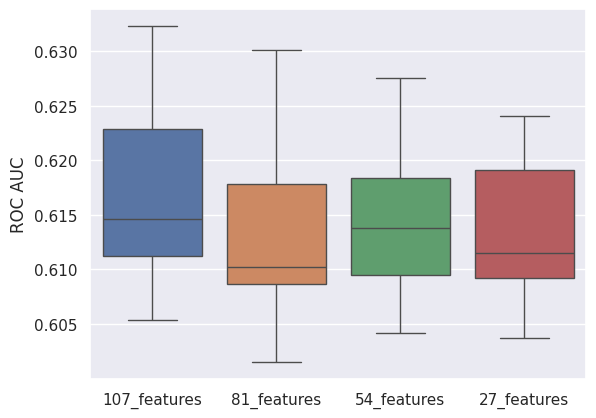

In [151]:
resultados_lgb_selected_features_corr=pd.DataFrame(resultados_lgb_selected_features_corr)
sns.boxplot(resultados_lgb_selected_features_corr)
plt.ylabel("ROC AUC")

In [152]:
resultados_lgb_selected_features_corr.describe()

,107_features,81_features,54_features,27_features
count,10.000000,10.000000,10.000000,10.000000
mean,0.616578,0.613441,0.613968,0.613398
std,0.008714,0.008351,0.007141,0.007426
min,0.605394,0.601540,0.604201,0.603742
25%,0.611254,0.608627,0.609458,0.609196
50%,0.614592,0.610245,0.613809,0.611537
75%,0.622846,0.617799,0.618409,0.619126
max,0.632332,0.630129,0.627504,0.624094


### Comparativo

Comparar os resultados obtidos obtidos com LightGBM treinado diferentes datasets.

*   Quatro datasets com features do dataset inicial completo;
*   Quatro datasets com features do dataset com as features previamente selecionadas através da correlação.



In [156]:
colunas=[column_name+'_lgb_complete' for column_name in resultados_lgb_complete_dataset.columns]
resultados_lgb_complete_dataset.columns=colunas

In [157]:
colunas=[column_name+'_lgb_corr' for column_name in resultados_lgb_selected_features_corr.columns]
resultados_lgb_selected_features_corr.columns=colunas

In [158]:
resultados_lgb=pd.concat([resultados_lgb_complete_dataset,resultados_lgb_selected_features_corr],axis=1)

In [159]:
resultados_lgb.describe()

,131_features_lgb_complete,99_features_lgb_complete,66_features_lgb_complete,33_features_lgb_complete,107_features_lgb_corr,81_features_lgb_corr,54_features_lgb_corr,27_features_lgb_corr
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.611295,0.612932,0.614196,0.601349,0.616578,0.613441,0.613968,0.613398
std,0.005429,0.005843,0.006175,0.005636,0.008714,0.008351,0.007141,0.007426
min,0.602761,0.603904,0.606681,0.590978,0.605394,0.601540,0.604201,0.603742
25%,0.609493,0.610179,0.610409,0.598850,0.611254,0.608627,0.609458,0.609196
50%,0.611008,0.611751,0.613755,0.602454,0.614592,0.610245,0.613809,0.611537
75%,0.613324,0.615966,0.615378,0.603267,0.622846,0.617799,0.618409,0.619126
max,0.620532,0.622012,0.624508,0.612639,0.632332,0.630129,0.627504,0.624094


([0, 1, 2, 3, 4, 5, 6, 7],
 [Text(0, 0, '131_features_lgb_complete'),
  Text(1, 0, '99_features_lgb_complete'),
  Text(2, 0, '66_features_lgb_complete'),
  Text(3, 0, '33_features_lgb_complete'),
  Text(4, 0, '107_features_lgb_corr'),
  Text(5, 0, '81_features_lgb_corr'),
  Text(6, 0, '54_features_lgb_corr'),
  Text(7, 0, '27_features_lgb_corr')])

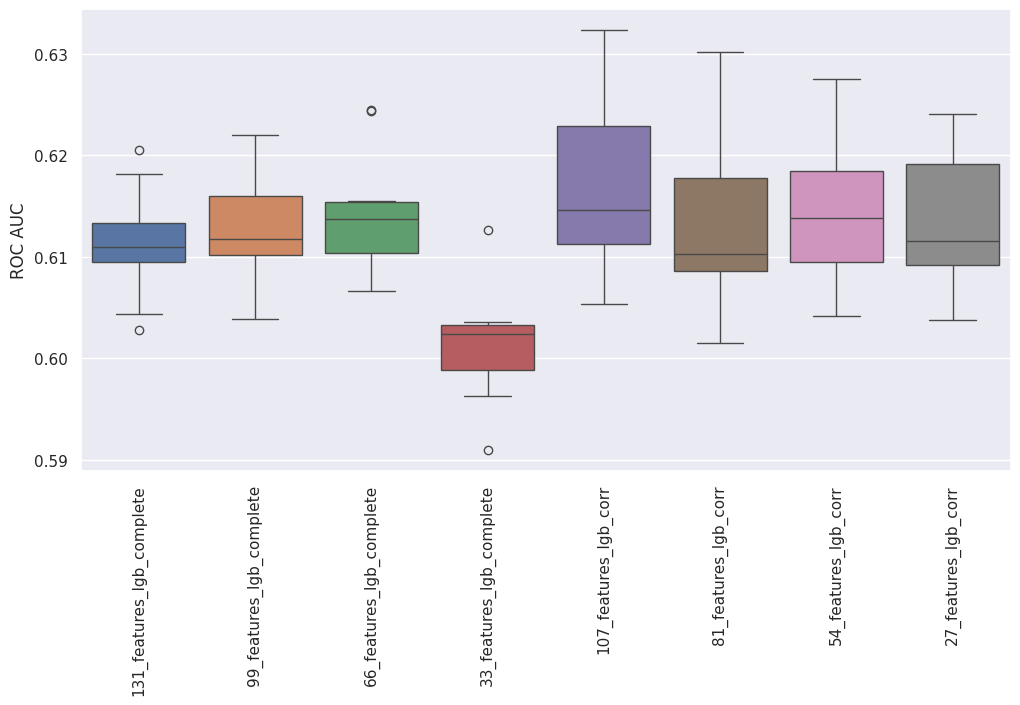

In [166]:
plt.figure(figsize=(12,6))
sns.boxplot(resultados_lgb)
plt.ylabel("ROC AUC")
plt.xticks(rotation=90)


Melhore resultado (maior média) com as 107 features do dataset com as features selecionadas pela correlação.